TL;DL

Do NOT use clustering LSH!!!!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# import os
import re
# import math
import time
# import timeit

import sounddevice as sd
from scipy.io import wavfile
# import IPython.display as ipd
# import soundfile as sf

from multiprocess import Pool
import functools
import pdb

import sys
sys.path.insert(1, './functions')

from workflow import *
from read import *
from musicalLSH import *
from helper import *
from display import *

In [50]:
# Setting up parameters to run the matching algorithm

midiPath = './ladispute.txt'
notes = midi_to_timeseries(midiPath)

# hyperparameters
zero_penalty = 1
length_incentive = 500000 # 50 seconds yields 10% increase in score
max_offset = 600
timestamp_max_before_source = 5000 #ms behing the source timestamp
min_dist_const = 400 # acceptable time difference for same note
initial_alignment = "last note in source to match in target"
realignment = "mean offset of notes within max_offset dist - done once"
note_scoring = "penalize within min_dist"

# parameters
minNotes = 8
maxNotes = 8 # max length of snippet to be calculated
minTime = 1500 # min time in ms
maxTime = 30000 # if more matches, increase snippet length
thresh = 0.7
start = 191400
skip = 10
end = 191430
# end = 365000
n = 3
k = 20
# k = 1000




In [29]:
permutation = [(randint(0, sys.maxsize), randint(0, sys.maxsize)) for i in range(128)]

In [15]:
# hashed_notes = get_notes_hashes(notes[:,1], n, permutation, minNotes, maxNotes)
data1, data2 = notes[100:108][:,1], notes[101:109][:,1]
data1, data2, type(data1)

(array([55, 51, 67, 53, 65, 60, 56, 56]),
 array([51, 67, 53, 65, 60, 56, 56, 53]),
 numpy.ndarray)

In [55]:
previous_clusters = dict() # key: feature vector
                           # value: (index, length, hash)
threshold_to_add_into_cluster = 0.95

In [6]:
def addToCluster(data: np.ndarray, index: int):
    h = tuple(get_hash(data, n, len(data), permutation)[0])
    # directly add a new cluster and return
    if len(previous_clusters) == 0:
        previous_clusters[h] = {(index, len(data), h)}
    else:
        # traverse all previous clusters to get the scores
        keys = list(previous_clusters.keys())
        scores = [1 - cosine(cluster, h) for cluster in keys]

        # add a new cluster
        if max(scores) < threshold_to_add_into_cluster:
            previous_clusters[h] = {(index, len(data), h)}
        # add to original cluster
        else:
            max_cluster = keys[scores.index(max(scores))]
            previous_clusters[max_cluster].add((index, len(data), h))

In [56]:
# 0,191400,10
for i in range(0, 758+1):
    for l in range(minNotes, maxNotes + 1):
        data = notes[i:i+l+1][:,1]
        addToCluster(data, i+l)

In [57]:
len(previous_clusters.keys())

8

In [9]:
first_cluster = dict(previous_clusters)

In [10]:
for i in range(759, 1514+1):
    for l in range(minNotes, maxNotes + 1):
        data = notes[i:i+l+1][:,1]
        addToCluster(data, i)

In [11]:
len(previous_clusters.keys())

12

In [ ]:
def calculate_similarity_time_ori(notes,source_id,currTime,timestamp_max_before_source=5000,zero_penalty=1,length_incentive=500000,max_offset=600,min_dist_const=400,skip=100,disp=False):
    """ Function that calls musical similarity on targets generated for a source_id.
        Target snips start at every 100 ms, and has same time length as source.
    
    Args:
        notes: list of all notes from a recording [[t,note,vel],[t,note,vel],[t,note,vel],...]
        source_id: indices of note array corresponding to current time snippet (source_id_start>source_id_end) 
                   [source_id_start, source_id_end]
        currTime: time stamp at which we are searching for matches (ms)
        max_matches: optional param to state how many matches to stop after
        skip: interval at which to iterate over target timestamps
        disp: boolean whether to print each match (defaults True)
    
    Returns:
        matches: list of matches [[currTime, pastTime1, score1], [currTime, pastTime2, score2],...] 
    
    """
    matches = []
    last_id_end = 0 # track previous end index of target
    last_id_start = 0
    source_id_start, source_id_end = source_id
    source_end = notes[source_id_end][0] # start and end time stamps of source
    length_ms = currTime - source_end #in milliseconds
    
    target_start = length_ms
    while target_start < currTime-timestamp_max_before_source:
        target_end = target_start - length_ms # pick target_end by time length of course snip
        
        # finding new end index
        for i in range(last_id_end,len(notes)):
            if notes[i][0] >= target_end:
                target_id_end = i
                break
             
        # finding new start index
        for i in range(target_id_end,len(notes)):
            if notes[i][0] > target_start:
                target_id_start = i
                break
        if target_id_end > target_id_start-4:
            last_id_end = target_id_end
            last_id_start = target_id_start
            target_start += skip
            continue
        if target_id_end == last_id_end and last_id_start == target_id_start:
            target_start += skip
            continue
        
        lm1,lm2,mo1,mo2,score = two_way_similarity(notes[source_id_end:source_id_start], notes[target_id_end:target_id_start],zero_penalty=zero_penalty,length_incentive=length_incentive,max_offset=max_offset,min_dist_const=min_dist_const,disp=disp)
        
        if score:
            if score>0.7:
#                 count += 1
                # Dsiplaying matches > 0.7 if disp is True
                if disp:
                    display_snippet_plot(notes, source_id_start, source_id_end, target_id_start, target_id_end, score, source_end, notes[target_id_end][0])
                    # play_match(piano_audio, currTime, source_end, target_start, target_end)
                    # predict(notes, source_id_start, source_id_end, target_id_start, target_id_end, currTime, target_start)
                    # time.sleep(5)
            if score>0.5:
                target_time = target_start
                
                # case 1 - good alignment of source snippet
                if lm1 >= source_id_start - source_id_end - 2:
                    target_time = notes[target_id_start-1][0] + int(mo2) + (currTime - notes[source_id_start-1][0])
                
                # case 2 - run again with target slightly ahead?
                elif lm2 >= target_id_start - target_id_end - 2:
                    if currTime - notes[source_id_end+lm1][0] < 1:
                        print("oops something went wrong with time calculations - might end in infinite loop")
                    target_start += currTime - notes[source_id_end+lm1][0]
                    continue
                
                # In all cases where good score and we do not rerun,
                # Find optimal timestamp and store the match
                target_time = notes[target_id_start-1][0] - int(mo2) + (currTime - notes[source_id_start-1][0])    
                if target_time<currTime-timestamp_max_before_source:
                    matches.append([currTime, target_time, score, source_id_start, source_id_end, time_to_index(notes, target_time), target_id_end])
        
        last_id_end = target_id_end
        last_id_start = target_id_start
        target_start += skip
        
    return matches


In [59]:
def calculate_similarity_time(previous_clusters,notes,n,k,permutation,source_id,minNotes,currTime,max_matches=None,timestamp_max_before_source=5000,zero_penalty=1,length_incentive=500000,max_offset=600,min_dist_const=400,skip = 100,disp=False):
    """ Function that calls musical similarity on targets generated for a source_id.
        Target snips start at every 100 ms, and has same time length as source.
    
    Args:
        notes: list of all notes from a recording [[t,note,vel],[t,note,vel],[t,note,vel],...]
        source_id: indices of note array corresponding to current time snippet (source_id_start>source_id_end) 
                   [source_id_start, source_id_end]
        currTime: time stamp at which we are searching for matches (ms)
        max_matches: optional param to state how many matches to stop after
        skip: interval at which to iterate over target timestamps
        disp: boolean whether to print each match (defaults True)
    
    Returns:
        matches: list of matches [[currTime, pastTime1, score1], [currTime, pastTime2, score2],...] 
    
    """
#     find_from_clusters(hashed_source: np.ndarray, k: int)
    matches = []
    last_id_end = 0 # track previous end index of target
    last_id_start = 0
    source_id_start, source_id_end = source_id
    source_end = notes[source_id_end][0] # start and end time stamps of source
    length_ms = currTime - source_end #in milliseconds

    sample = notes[source_id_end:source_id_start][:,1]
    len_of_notes = len(sample)
    source_hash = get_hash(sample, n, len_of_notes, permutation)[0]
#     target_hash = hashed_notes[len_of_notes - minNotes][:source_id_end]
    # print("source_id_start:{}, source_id_end:{}, target_id_start:{}, target_id_end:{}".format(source_id_start, source_id_end, target_id_start, target_id_end))
#     indices = get_k_highest_scores(target_hash, source_hash, k)
    indices = find_from_clusters(source_hash, k)
    dist = currTime - notes[source_id_start-1][0]
    print('source_id_end: {}, source timestamp: {}, expected: {}'.format(source_id_end, currTime, currTime - 191400))
    for target_id_end, length in indices:
        print('target timestamp: {}, length: {}'.format(notes[target_id_end][0]+dist, length))
    
    target_start = length_ms
    return matches

    for target_id_end, length in indices:
        # print(target_id_end)
        target_id_start = target_id_end + length

        lm1,lm2,mo1,mo2,score = two_way_similarity(notes[source_id_end:source_id_start], notes[target_id_end:target_id_start],zero_penalty=zero_penalty,length_incentive=length_incentive,max_offset=max_offset,min_dist_const=min_dist_const,disp=disp)

        if score:
            # if score>0.7:
    #                 count += 1
                # Dsiplaying matches > 0.7 if disp is True
            if disp:
                display_snippet_plot(notes, source_id_start, source_id_end, target_id_start, target_id_end, score, source_end, notes[target_id_end][0])
                    # play_match(piano_audio, currTime, source_end, target_start, target_end)
                    # predict(notes, source_id_start, source_id_end, target_id_start, target_id_end, currTime, target_start)
                    # time.sleep(5)

            # if score>0.5:
            if True:
                target_time = target_start
                
                # case 1 - good alignment of source snippet
                if lm1 >= source_id_start - source_id_end - 2:
                    target_time = notes[target_id_start-1][0] + int(mo2) + (currTime - notes[source_id_start-1][0])
                
                # case 2 - run again with target slightly ahead?
                elif lm2 >= target_id_start - target_id_end - 2:
                    if currTime - notes[source_id_end+lm1][0] < 1:
                        print("oops something went wrong with time calculations - might end in infinite loop")
                    target_start += currTime - notes[source_id_end+lm1][0]
                    continue
            
                # In all cases where good score and we do not rerun,
                # Find optimal timestamp and store the match
                target_time = notes[target_id_start-1][0] - int(mo2) + (currTime - notes[source_id_start-1][0])    
                if target_time<currTime-5000:
                    # print("source_id_start:{}, source_id_end:{}, target_id_start:{}, target_id_end:{}, score:{}".format(source_id_start, source_id_end, target_id_start, target_id_end, score))
                    matches.append([currTime, target_time, score, source_id_start, source_id_end, time_to_index(notes, target_time), target_id_end])

    return matches

def get_source_notes(notes, start_time, min_notes, max_notes, min_time):
    """ Function that ...
    
    Args:
        notes: array of all notes in a recording, where each note is [t,note,vel]
        start_time: start index of notes array - corresponding to current time
        min_notes: min number of notes for a valid sequence, integer
        max_notes: max note length for a snippet, integer
        min_time: min time length for a valid sequence, integer (ms)\
    
    Returns:
        matches: list of matches [[currTime, pastTime1, score1], [currTime, pastTime2, score2],...] 
    
    """
    start_index = np.argwhere(notes[:,0] > start_time)
    if start_index.any():
        start_index = start_index[0]
    else:
        print("Error: Start time too large")
        return np.array([None,None])
    
    if start_index<min_notes:
        return np.array([None,None])
    
    end_index = np.arange(start_index-min_notes, start_index - max_notes - 1, -1)
    ids = (start_time - notes[end_index,0] >= min_time) * end_index
    ids = ids[np.nonzero(ids)]
    if ids.any():
        source_id = np.array([start_index[0],ids[0]])
        return source_id
        
    return np.array([None,None])

def find_matches_at_timestamp(i,n,k,previous_clusters,permutation,notes,minNotes,minTime,maxNotes,maxTime,thresh,timestamp_max_before_source=5000,zero_penalty=1,length_incentive=500000,max_offset=600,min_dist_const=400,disp=False):
    """Function that finds similarity from lengths minNotes to maxNotes ...
    
    Args:
        i:
        notes:
        minNotes:
        minTime:
        maxNotes:
        maxTime:
        thresh:
        disp:
    
    Returns:
        sims_arr: np array of every match >0.5 found of the form -
            ['source_timestamp', 'target_timestamp','score',
            'source_id_start','source_id_end','target_id_start','target_id_end','match_len','match_time']
    
    """
    sims_arr = []
    print("\n",end="")
    print("i:",i,end="   ")
    offset = 500
    numSourceNotes = 0
    sourceTime = 0
    while sourceTime < maxTime and numSourceNotes < maxNotes:
        sourceId = get_source_notes(notes, i, minNotes, maxNotes, sourceTime+offset)
        if not sourceId.any():
            break

        # num notes in source snippet
        numSourceNotes = (sourceId[0] - sourceId[1])
        # total time in ms in source snippet
        sourceTime = i - notes[sourceId[1]][0]
        
        sim = calculate_similarity_time(previous_clusters,notes,n,k,permutation,sourceId,minNotes,i,timestamp_max_before_source=timestamp_max_before_source,zero_penalty=zero_penalty,length_incentive=length_incentive,max_offset=max_offset,min_dist_const=min_dist_const,disp=disp)
        for match in sim:
            match.append(numSourceNotes)
            match.append(sourceTime)
        sims_arr.extend(sim)
        offset += 500

    return np.array(sims_arr)



In [18]:
temp_cluster_dict = dict(previous_clusters)

In [52]:
start = 200000
end = 220000
skip = 1000

In [19]:
def find_from_clusters(hashed_source: np.ndarray, k: int):
    # find cluster
    keys = list(previous_clusters.keys())
    scores = [1 - cosine(cluster, hashed_source) for cluster in keys]
    ind = scores.index(max(scores))
    snippets = list(previous_clusters[keys[ind]])
    
    # find snippet
    scores = [1 - cosine(snippet, hashed_source) for _, _, snippet in snippets]
    k_snippets = list(reversed(np.argsort(scores)[-k:]))
    
    return [(snippets[i][0], snippets[i][1]) for i in k_snippets]

In [60]:
start, end, skip

(200000, 220000, 1000)

In [61]:
sims_arr = [[]]
curr_times = np.arange(start, end, skip)
# curr_times = [start+10000]
# num_speedups = 0

for i in curr_times:
    sims_arr.append(find_matches_at_timestamp(i,n=n, k=k, previous_clusters=previous_clusters, 
                       permutation=permutation, notes=notes, minNotes=minNotes, 
                       minTime=minTime, maxNotes=maxNotes, maxTime=maxTime, thresh=thresh, 
                       timestamp_max_before_source=timestamp_max_before_source, 
                       zero_penalty=zero_penalty, length_incentive=length_incentive, max_offset=max_offset, 
                       min_dist_const=min_dist_const, disp=False))


i: 200000   source_id_end: 781, source timestamp: 200000, expected: 8600
target timestamp: 104907, length: 9
target timestamp: 115717, length: 9
target timestamp: 104063, length: 9
target timestamp: 8570, length: 9
target timestamp: 9140, length: 9
target timestamp: 9126, length: 9
target timestamp: 58409, length: 9
target timestamp: 58417, length: 9
target timestamp: 9777, length: 9
target timestamp: 8568, length: 9
target timestamp: 114820, length: 9
target timestamp: 119011, length: 9
target timestamp: 19337, length: 9
target timestamp: 118395, length: 9
target timestamp: 118967, length: 9
target timestamp: 118715, length: 9
target timestamp: 57802, length: 9
target timestamp: 51209, length: 9
target timestamp: 58395, length: 9
target timestamp: 57839, length: 9

i: 201000   source_id_end: 785, source timestamp: 201000, expected: 9600
target timestamp: 54636, length: 9
target timestamp: 2993, length: 9
target timestamp: 102058, length: 9
target timestamp: 102330, length: 9
target t

i: 211000   source_id_end: 816, source timestamp: 211000, expected: 19600
target timestamp: 33953, length: 9
target timestamp: 33948, length: 9
target timestamp: 33368, length: 9
target timestamp: 34573, length: 9
target timestamp: 92482, length: 9
target timestamp: 33351, length: 9
target timestamp: 38197, length: 9
target timestamp: 91538, length: 9
target timestamp: 91890, length: 9
target timestamp: 91009, length: 9
target timestamp: 92173, length: 9
target timestamp: 56744, length: 9
target timestamp: 26173, length: 9
target timestamp: 26744, length: 9
target timestamp: 38174, length: 9
target timestamp: 42434, length: 9
target timestamp: 26137, length: 9
target timestamp: 56754, length: 9
target timestamp: 37585, length: 9
target timestamp: 41736, length: 9

i: 212000   source_id_end: 818, source timestamp: 212000, expected: 20600
target timestamp: 20582, length: 9
target timestamp: 88936, length: 9
target timestamp: 21210, length: 9
target timestamp: 21199, length: 9
target time

In [22]:
end = 212060

In [264]:
sims_arr

[[],
 array([[1.91400000e+05, 1.50830000e+05, 1.22911355e-01, ...,
         4.96000000e+02, 8.00000000e+00, 2.18950000e+04],
        [1.91400000e+05, 1.50830000e+05, 1.22917970e-01, ...,
         4.95000000e+02, 8.00000000e+00, 2.18950000e+04],
        [1.91400000e+05, 1.58010000e+05, 1.13910534e-01, ...,
         5.40000000e+02, 8.00000000e+00, 2.18950000e+04],
        ...,
        [1.91400000e+05, 1.69719000e+05, 2.80967680e-01, ...,
         6.19000000e+02, 8.00000000e+00, 2.18950000e+04],
        [1.91400000e+05, 1.70017000e+05, 2.32954610e-01, ...,
         6.18000000e+02, 8.00000000e+00, 2.18950000e+04],
        [1.91400000e+05, 1.69719000e+05, 1.58219105e-01, ...,
         6.19000000e+02, 8.00000000e+00, 2.18950000e+04]]),
 array([[1.91410000e+05, 1.50840000e+05, 1.22911355e-01, ...,
         4.96000000e+02, 8.00000000e+00, 2.19050000e+04],
        [1.91410000e+05, 1.50840000e+05, 1.22917970e-01, ...,
         4.95000000e+02, 8.00000000e+00, 2.19050000e+04],
        [1.91410000e

In [23]:
## choosing only significant scores and storing the new data in sims_plot

sarr = []
for i in range(len(sims_arr)):
    sarr.extend(sims_arr[i])

sarr = np.array(sarr)

In [24]:
sims_thresh = sarr * (sarr>thresh) # considering a match if score greater than a threshold



In [25]:
simsDF = pd.DataFrame(data=sims_thresh.copy(), columns=['source_timestamp', 'target_timestamp','score','source_id_start','source_id_end','target_id_start','target_id_end','match_len','match_time'])
simsDFall = pd.DataFrame(data=sarr.copy(), columns=['source_timestamp', 'target_timestamp','score','source_id_start','source_id_end','target_id_start','target_id_end','match_len','match_time'])


<Axes: title={'center': 'All matches >0.7, for \nMin Notes=8 notes, Max Notes=8'}, xlabel='source_timestamp', ylabel='target_timestamp'>

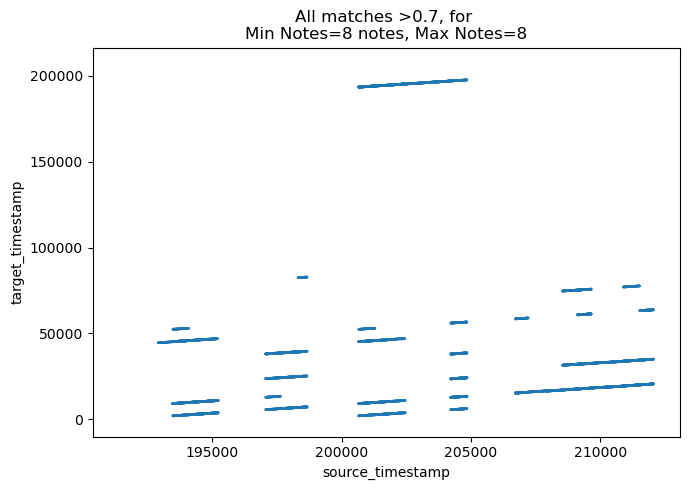

In [26]:
# plotting all mathes > threshold score

plt.rcParams["figure.figsize"] = [7, 5]
plt.rcParams["figure.autolayout"] = True

title = "All matches >"+str(thresh)+", for \nMin Notes=" + str(minNotes) + " notes, Max Notes=" + str(maxNotes)
simsDF.plot.scatter(x="source_timestamp", y="target_timestamp", s='score', title=title)


Percentage matches found: 100.0%
Percentage matches >0.7 found: 65.2%
Percentage matches within 50ms of line: 17.0%
Percentage matches >0.7 and within 50ms of the line: 17.0%
Minimum score of a "right match": 0.82


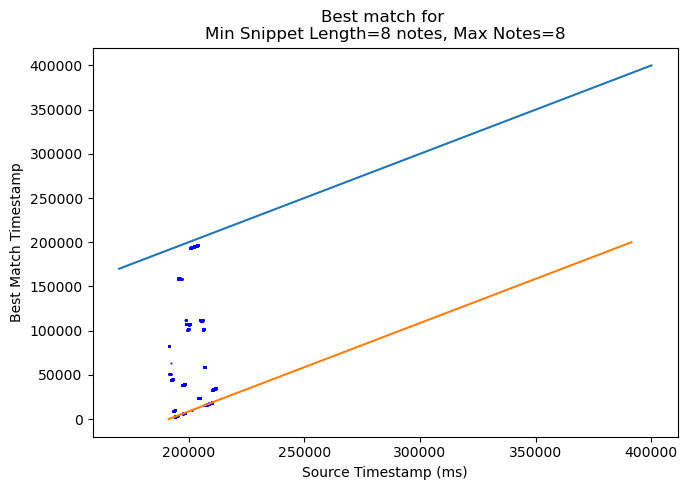

In [27]:
# Plotting best match only

percentage_matches_any = 0
percentage_matches_thresh = 0
percentage_matches_line = 0
percentage_matches_thresh_line = 0
acc = 50                            #ms accuracy for distance from line

plt.rcParams["figure.figsize"] = [7, 5]
plt.rcParams["figure.autolayout"] = True
bestMatches = []

toPlot = simsDFall
# toPlot = simsDFall_old

total = 0
distribution_hist = []
distribution_all = []
close_matches = []
min_good_score = 1
for x in range(start,end,skip):
    y = toPlot.loc[toPlot['source_timestamp'] == x]['score']
    total += 1
    if y.any(): 
        y = y.idxmax()
        percentage_matches_any += 1
        if toPlot['score'].loc[y] > thresh:
            percentage_matches_thresh += 1
            if np.abs(toPlot['target_timestamp'].loc[y]-(x-191400))<acc:
                percentage_matches_thresh_line += 1
        if np.abs(toPlot['target_timestamp'].loc[y]-(x-191400))<acc:
            if toPlot['score'].loc[y] < min_good_score:
                min_good_score = toPlot['score'].loc[y]
            distribution_hist.append((toPlot['target_timestamp'].loc[y]-(x-191400)))
            distribution_all.append([x,(toPlot['target_timestamp'].loc[y]-(x-191400))])
            percentage_matches_line += 1
            close_matches.append(toPlot.loc[y].tolist())
    else:
        continue
#     bestMatch = [toPlot['source_timestamp'].loc[y],toPlot['target_timestamp'].loc[y],toPlot['score'].loc[y],toPlot['source_id_start'].loc[y],toPlot['source_id_end'].loc[y],toPlot['target_id_start'].loc[y],toPlot['target_id_end'].loc[y]]
#     bestMatches.append(bestMatch)
    plt.scatter(toPlot['source_timestamp'].loc[y],toPlot['target_timestamp'].loc[y],toPlot['score'].loc[y],c='blue')
# bestMatches = np.array(bestMatches)
# bestMatchesDF = pd.DataFrame(data=bestMatches, columns=["source_timestamp","target_timestamp", "score", "source_id_start", "source_id_end", "target_id_start", "target_id_end"])   

plt.plot(np.arange(170000,400000),np.arange(170000,400000))
plt.plot(np.arange(191400,391400),np.arange(200000))
percentage_matches_any /= total
percentage_matches_thresh /= total
percentage_matches_line /= total
percentage_matches_thresh_line /= total
print("Percentage matches found: {:.1f}%".format(percentage_matches_any*100))
print("Percentage matches >{:.1f} found: {:.1f}%".format(thresh,percentage_matches_thresh*100))
print("Percentage matches within {:d}ms of line: {:.1f}%".format(acc,percentage_matches_line*100))
print("Percentage matches >{:.1f} and within {:d}ms of the line: {:.1f}%".format(thresh,acc,percentage_matches_thresh_line*100))
print("Minimum score of a \"right match\": {:.2f}".format(min_good_score))

plt.title("Best match for \nMin Snippet Length=" + str(minNotes) + " notes, Max Notes=" + str(maxNotes))
plt.xlabel("Source Timestamp (ms)")
plt.ylabel("Best Match Timestamp")
plt.show()


In [220]:
n

3

In [212]:
data = notes[1515:1515+8][:,1]

In [213]:
h = tuple(get_hash(data, n, len(data), permutation)[0])

In [185]:
keys = list(previous_clusters.keys())
scores = [1 - cosine(cluster, h) for cluster in keys]

In [186]:
scores

[0.9978076273508656,
 0.9325352844172773,
 0.8754007185186585,
 0.9488907051639058,
 0.8665557267034658,
 0.8451718708643032,
 0.9377508559732469]

In [191]:
ind = scores.index(max(scores))
ind

0

In [201]:
snippets = list(previous_clusters[keys[ind]])

In [202]:
len(snippets)

4863

In [203]:
scores = [1 - cosine(snippet, h) for _, _, snippet in snippets] # h: hashed_source

In [204]:
list(reversed(np.argsort(scores)[-5:]))

[490, 711, 4784, 1832, 1693]

In [209]:
snippets[490][0], snippets[490][1]

(788, 9)

In [215]:
snippets[711][0], snippets[711][1]

(787, 10)

In [217]:
snippets[4784][0], snippets[4784][1]

(912, 10)

In [218]:
snippets[1832][0], snippets[1832][1]

(907, 14)

In [216]:
snippets[1693][0], snippets[1693][1]

(908, 13)

In [198]:
data

array([63, 58, 55, 58, 51, 70, 55, 58])

In [210]:
notes[788:788+9][:,1]

array([58, 58, 55, 70, 51, 58, 55, 55, 63])

In [214]:
find_from_clusters(h, 5)

[(788, 9), (787, 10), (912, 10), (907, 14), (908, 13)]

In [156]:
data

array([51, 63, 55, 58, 58, 55, 70, 51, 55, 58, 55, 63, 50, 62, 59, 55])

In [152]:
np.where(abs(notes[:,0] - 191400) < 1000)

(array([758, 759, 760, 761]),)

In [154]:
notes[755:760]

array([[171193,     55,     56],
       [172336,     60,     56],
       [172358,     72,     70],
       [191674,     51,     49],
       [191677,     63,     47]])

In [161]:
notes[1510:1518]

array([[362732,     55,     56],
       [362741,     75,     60],
       [363880,     60,     62],
       [363886,     72,     67],
       [413583,     51,     46],
       [413594,     63,     44],
       [414224,     58,     37],
       [414242,     55,     39]])

In [132]:
addToCluster(data1, 100)

In [133]:
addToCluster(data2, 101)

In [112]:
previous_clusters

{(0.5792819300549311,
  0.017784425857862687,
  0.13582186738945734,
  0.8309345058475656,
  0.3999494306967685,
  0.04850981430460316,
  0.3216284489031633,
  0.010875684477941523,
  0.016067072877949475,
  0.7059162410135207,
  0.7452482612999792,
  0.019605782081314714,
  0.5033124518679725,
  0.3923387551735851,
  0.023893955132033077,
  0.6505012091181848,
  0.3278974194187412,
  0.03573877001552488,
  0.024434642809635792,
  0.16552903522409984,
  0.06674546165381999,
  0.6071556209011668,
  0.2752643231462964,
  0.19434279046384367,
  0.4115570259848446,
  0.5675645738617374,
  0.6397360279072879,
  0.09526398146248224,
  0.30359189343579285,
  0.3988074453447379,
  0.03956717885381143,
  0.08840121370317014,
  0.530842924660195,
  0.5519799277281534,
  0.36656803943729405,
  0.5056581110283485,
  0.17155104674447424,
  0.09043982226945275,
  0.5898889115643144,
  0.018198250560159026,
  0.3151991586091907,
  0.30687659929394673,
  0.14197438633396597,
  0.48775688574660925,
  0

In [64]:
k = list(previous_clusters.keys())[0]
previous_clusters[k]

{(101, 8), 100, 8}

In [115]:
len(notes)

2992

In [125]:
data3 = notes[200:208][:,1]

In [126]:
data1, data2, data3

(array([55, 51, 67, 53, 65, 60, 56, 56]),
 array([51, 67, 53, 65, 60, 56, 56, 53]),
 array([50, 62, 55, 59, 59, 55, 50, 55]))

In [134]:
addToCluster(data3, 200)

In [135]:
len(previous_clusters.keys())

2

In [136]:
previous_clusters

{(0.5792819300549311,
  0.017784425857862687,
  0.13582186738945734,
  0.8309345058475656,
  0.3999494306967685,
  0.04850981430460316,
  0.3216284489031633,
  0.010875684477941523,
  0.016067072877949475,
  0.7059162410135207,
  0.7452482612999792,
  0.019605782081314714,
  0.5033124518679725,
  0.3923387551735851,
  0.023893955132033077,
  0.6505012091181848,
  0.3278974194187412,
  0.03573877001552488,
  0.024434642809635792,
  0.16552903522409984,
  0.06674546165381999,
  0.6071556209011668,
  0.2752643231462964,
  0.19434279046384367,
  0.4115570259848446,
  0.5675645738617374,
  0.6397360279072879,
  0.09526398146248224,
  0.30359189343579285,
  0.3988074453447379,
  0.03956717885381143,
  0.08840121370317014,
  0.530842924660195,
  0.5519799277281534,
  0.36656803943729405,
  0.5056581110283485,
  0.17155104674447424,
  0.09043982226945275,
  0.5898889115643144,
  0.018198250560159026,
  0.3151991586091907,
  0.30687659929394673,
  0.14197438633396597,
  0.48775688574660925,
  0

In [ ]:
print('ss')

0.945085782667998
[5035   55   45]
[197053     50     42]
Oops, hashing
0.9454654751606593
[5035   55   45]
[197053     50     42]
Oops, hashing
0.9454627995115137
[5035   55   45]
[197053     50     42]
Oops, hashing
0.945085782667998
[5665   71   55]
[197053     50     42]
Oops, hashing
0.9454627942828754
[5665   71   55]
[197053     50     42]
Oops, hashing
0.9455245481774678
[5665   71   55]
[197053     50     42]
Oops, hashing
0.9454645446893246
[6271   55   51]
[197640     59     37]
Oops, hashing
0.9454627942828754
[6271   55   51]
[197640     59     37]
Oops, hashing
0.9455245481774678
[6271   55   51]
[197640     59     37]
Oops, hashing
0.945085782667998
[6819   55   48]
[198291     55     46]
Oops, hashing
0.9454654751606593
[6819   55   48]
[198291     55     46]
Oops, hashing
0.9454627942828754
[6819   55   48]
[198291     55     46]
Oops, hashing
0.9455245481774678
[6819   55   48]
[198291     55     46]
Oops, hashing
0.9450855072832826
[7045   62   49]
[198504     62    

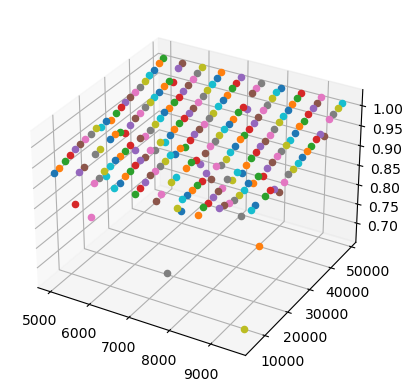

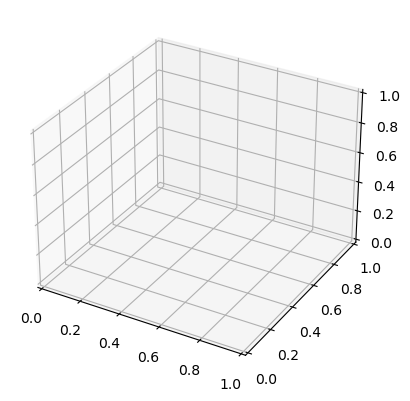

In [12]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

fig2 = plt.figure()
ax2 = fig2.add_subplot(projection='3d')

# matches=[]
for x in range(5000,10000,500):
#     print(x)
#     x = 0
    for y in range(5000,50000,2000):
        t1 = [y+x,0+x] # timestamps in ms
        t2 = [191400+y+x,191400+x]
#         t2 = [413000+y+x,413000+x]
#         t2 = [587000+y+x,587000+x]

        tf1 = time_to_sequence(notes, t1)
        tf2 = time_to_sequence(notes, t2)

#         a,b,c,d,score = musical_similarity(tf1,tf2,True)
        a,b,c,d,score = two_way_similarity(tf1,tf2,True)
#         print("two way score:", score)
#         matches.append([x,y,score])
        ax.scatter(x,y,score)
    
        data1 = np.array(tf1)[:,1]
        data2 = np.array(tf2)[:,1]
        h1 = get_hash(data1, n, len(data1), permutation)[0]
        h2 = get_hash(data2, n, len(data2), permutation)[0]
        score2 = 1 - cosine(h1, h2)
#         print("hash score:", score2)
#         ax2.scatter(x,y,score2)
    
    
        if score<0.8:
            print("Oops, two way")
        if score2 < 0.99:
            print(score2)
            print(tf1[0])
            print(tf2[0])
            print("Oops, hashing")
#             a,b,c,d,score = two_way_similarity(tf1,tf2,True)
#             display_snippet_plot(notes, time_to_index(notes,t1[0]),time_to_index(notes,t1[1]),time_to_index(notes,t2[0]),time_to_index(notes,t2[1]), score, t1[0], t2[0])
    #         play_match(t1[0],t1[1],t2[0],t2[1])
    #         predict(notes, time_to_index(notes,t1[0]), time_to_index(notes,t1[1]), time_to_index(notes,t2[0]),time_to_index(notes,t2[1]), tf1[-1][0],pred_time=100,sound=True)
    #         time.sleep(2)
#         break
#     break

# plt.scatter3D(matches)
# ax.set_xlabel('Start position (ms)')
# ax.set_ylabel('Length of snip (ms)')
# ax.set_zlabel('Score')
# plt.show()

# ax2.set_xlabel('Start position (ms)')
# ax2.set_ylabel('Length of snip (ms)')
# ax2.set_zlabel('Score')
# plt.show()

In [286]:
x = 5000
y = 5000
t1 = [y+x,0+x] # timestamps in ms
t2 = [191400+y+x,191400+x]

        

In [287]:
tf1 = time_to_sequence(notes, t1)

In [288]:
tf1

[array([5035,   55,   45]),
 array([5059,   59,   39]),
 array([5665,   71,   55]),
 array([5676,   50,   45]),
 array([6271,   55,   51]),
 array([6276,   59,   34]),
 array([6819,   55,   48]),
 array([6835,   59,   29]),
 array([7045,   62,   49]),
 array([7121,   63,   54]),
 array([7205,   65,   59]),
 array([7388,   63,   54]),
 array([7405,   51,   53]),
 array([8027,   58,   36]),
 array([8029,   55,   44]),
 array([8585,   55,   49]),
 array([8599,   58,   44]),
 array([9236,   70,   58]),
 array([9247,   51,   46]),
 array([9846,   55,   45]),
 array([9849,   58,   32])]

In [290]:
np.array(tf1)[:,1]

array([55, 59, 71, 50, 55, 59, 55, 59, 62, 63, 65, 63, 51, 58, 55, 55, 58,
       70, 51, 55, 58])